### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
np.set_printoptions(threshold=np.inf)

%matplotlib inline

import geopandas as gpd
import geoplot
import fiona
import json

# Part 1: Reading and Preparing the Data

Here we read in the gps data and conduct the necessary column transformations.

In [2]:
gps_data = pd.read_csv("gps.csv", encoding='cp1252')
gps_data['Timestamp'] = pd.to_datetime(gps_data['Timestamp'], infer_datetime_format=True)
gps_data = gps_data.astype({'id': 'float'})
gps_data.rename(columns={'id':'CarID'}, inplace=True)
gps_data.info()
gps_data.head(8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685169 entries, 0 to 685168
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Timestamp  685169 non-null  datetime64[ns]
 1   CarID      685169 non-null  float64       
 2   lat        685169 non-null  float64       
 3   long       685169 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 20.9 MB


,Timestamp,CarID,lat,long
0,2014-01-06 06:28:01,35.0,36.076225,24.874689
1,2014-01-06 06:28:01,35.0,36.076220,24.874596
2,2014-01-06 06:28:03,35.0,36.076211,24.874443
3,2014-01-06 06:28:05,35.0,36.076217,24.874253
4,2014-01-06 06:28:06,35.0,36.076214,24.874167
5,2014-01-06 06:28:07,35.0,36.076191,24.874056
6,2014-01-06 06:28:09,35.0,36.076194,24.873906
7,2014-01-06 06:28:10,35.0,36.076183,24.873814


We have done the above steps for the car, credit, and loyalty as well and saved the transformed data into pickle files for each set. Next we will read those in.

In [3]:
car_df = pd.read_pickle('car_df.pkl')
credit_df = pd.read_pickle('credit_df.pkl')
loyalty_df = pd.read_pickle('loyalty_df.pkl')

Now we build our full dataframe of the car data combined with the gps data.

In [4]:
gps_data.reset_index()
car_df.reset_index()
car_gps_df = pd.merge(gps_data, car_df, left_on='CarID', right_on='CarID', how='left')
print(car_df[car_df['CarID'] == 35.0])
car_gps_df.head()

      LastName FirstName  CarID CurrentEmploymentType  \
34  Vasco-Pais    Willem   35.0             Executive   

          CurrentEmploymentTitle  
34  Environmental Safety Advisor  


,Timestamp,CarID,lat,long,LastName,FirstName,CurrentEmploymentType,CurrentEmploymentTitle
0,2014-01-06 06:28:01,35.0,36.076225,24.874689,Vasco-Pais,Willem,Executive,Environmental Safety Advisor
1,2014-01-06 06:28:01,35.0,36.076220,24.874596,Vasco-Pais,Willem,Executive,Environmental Safety Advisor
2,2014-01-06 06:28:03,35.0,36.076211,24.874443,Vasco-Pais,Willem,Executive,Environmental Safety Advisor
3,2014-01-06 06:28:05,35.0,36.076217,24.874253,Vasco-Pais,Willem,Executive,Environmental Safety Advisor
4,2014-01-06 06:28:06,35.0,36.076214,24.874167,Vasco-Pais,Willem,Executive,Environmental Safety Advisor


We will add some more columns and sort our data.

In [5]:
car_gps_df['fullName'] = car_gps_df['FirstName'] + " " + car_gps_df['LastName']
car_gps_df['Date'] = car_gps_df['Timestamp'].map(lambda x: x.date())
car_gps_df.sort_values(by=['Timestamp', 'CarID'], inplace=True)
car_gps_df["CarID"] = car_gps_df["CarID"].astype(str)

In [6]:
loyalty_df['fullName'] = loyalty_df['FirstName'] + " " + loyalty_df['LastName']
credit_df['fullName'] = credit_df['FirstName'] + " " + credit_df['LastName']
loyalty_df['date'] = loyalty_df['timestamp'].map(lambda x: x.date())
credit_df['date'] = credit_df['timestamp'].map(lambda x: x.date())

Let's read in our geospatial data.

In [7]:
abila = fiona.open('Geospatial/Abila.shp')

abila_df = pd.DataFrame(list(abila))

abila_df['singles'] = abila_df['geometry'].apply(lambda x: True if len(x['coordinates']) == 1 else False)
abila_df['singles'].value_counts()
abila_geo = abila_df[abila_df['singles'] == False]
abila_geo.drop(columns=['singles'], inplace=True)

abila_json = json.loads(abila_geo.to_json(orient='records'))
abila_gdf = gpd.GeoDataFrame.from_features(abila_json)

/var/folders/wn/1pqs9zvs4d7306tpghptydnc0000gn/T/ipykernel_9010/3821076763.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abila_geo.drop(columns=['singles'], inplace=True)


In [8]:
img = plt.imread('map-tourist.jpg')

We will combine our credit and loyalty data into an overall transactions dataset, and remove any duplicates.

In [35]:
credit_df['type'] = 'Credit'
loyalty_df['type'] = 'Loyalty'

In [36]:
transactions = pd.concat([credit_df, loyalty_df], ignore_index=True)
transactions.sort_values(by=['location', 'timestamp'], inplace=True)
transactions.drop_duplicates(subset=['location', 'price', 'fullName', 'date'], inplace=True)
transactions.head(10)

,timestamp,location,price,FirstName,LastName,fullName,date,type
1823,2014-01-06 00:00:00,Abila Airport,4540.08,Albina,Hafon,Albina Hafon,2014-01-06,Loyalty
1824,2014-01-06 00:00:00,Abila Airport,777.06,Albina,Hafon,Albina Hafon,2014-01-06,Loyalty
1833,2014-01-06 00:00:00,Abila Airport,612.47,Henk,Mies,Henk Mies,2014-01-06,Loyalty
48,2014-01-06 12:16:00,Abila Airport,1873.79,Henk,Mies,Henk Mies,2014-01-06,Credit
1914,2014-01-07 00:00:00,Abila Airport,3840.37,Benito,Hawelon,Benito Hawelon,2014-01-07,Loyalty
1920,2014-01-07 00:00:00,Abila Airport,124.89,Henk,Mies,Henk Mies,2014-01-07,Loyalty
1921,2014-01-07 00:00:00,Abila Airport,3411.29,Henk,Mies,Henk Mies,2014-01-07,Loyalty
1952,2014-01-07 00:00:00,Abila Airport,1641.96,Dylan,Scozzese,Dylan Scozzese,2014-01-07,Loyalty
2017,2014-01-08 00:00:00,Abila Airport,2723.18,Henk,Mies,Henk Mies,2014-01-08,Loyalty
2018,2014-01-08 00:00:00,Abila Airport,2769.12,Henk,Mies,Henk Mies,2014-01-08,Loyalty


We will also create an additional cross section of our data that shows the total spend by an employee on a given date at a given location.

In [10]:
grouped_transactions = transactions.groupby(by=['location', 'date', 'fullName'], as_index=False)['price'].sum()
grouped_transactions = grouped_transactions[grouped_transactions['price'] > 0.0]
grouped_transactions.head()

,location,date,fullName,price
0,Abila Airport,2014-01-06,Albina Hafon,5317.14
1,Abila Airport,2014-01-06,Henk Mies,2486.26
2,Abila Airport,2014-01-07,Benito Hawelon,3840.37
3,Abila Airport,2014-01-07,Dylan Scozzese,1641.96
4,Abila Airport,2014-01-07,Henk Mies,3536.18


Next lets build a roster of all the employees and their roles.

In [11]:
car_df['fullName'] = car_df['FirstName'] + " " + car_df['LastName']
emp_titles = car_df[['fullName', 'CurrentEmploymentType', 'CurrentEmploymentTitle']].drop_duplicates().copy()
emp_titles.head()

,fullName,CurrentEmploymentType,CurrentEmploymentTitle
0,Lucas Alcazar,Information Technology,IT Helpdesk
1,Lars Azada,Engineering,Engineer
2,Felix Balas,Engineering,Engineer
3,Ingrid Barranco,Executive,SVP/CFO
4,Isak Baza,Information Technology,IT Technician


We will combine our roster with the transactions data to get the total spend in our dataset per employee.

In [12]:
totals = transactions.groupby(by='fullName', as_index=False).sum().sort_values(by='price', ascending=False)
spend = totals.merge(emp_titles, how='inner', on='fullName').sort_values(by='price', ascending=False)
spend

,fullName,price,CurrentEmploymentType,CurrentEmploymentTitle
0,Valeria Morlun,51522.83,Facilities,Truck Driver
1,Henk Mies,44107.97,Facilities,Truck Driver
2,Cecilia Morluniau,42517.18,Facilities,Truck Driver
3,Dylan Scozzese,34296.59,Facilities,Truck Driver
4,Irene Nant,32387.95,Facilities,Truck Driver
5,Albina Hafon,24186.94,Facilities,Truck Driver
6,Benito Hawelon,24023.33,Facilities,Truck Driver
7,Adan Morlun,17185.95,Facilities,Truck Driver
8,Claudio Hawelon,13028.12,Facilities,Truck Driver
9,Lucas Alcazar,11913.34,Information Technology,IT Helpdesk


Next we build a roster of all the (latitude, longitude) coordinates where employees have been per the gps data.

In [13]:
car_gps_df[['lat','long']] = round(car_gps_df[['lat','long']], 3)
pois = car_gps_df.groupby(by=['Timestamp', 'lat','long'], as_index=False)['fullName'].count()
pois.sort_values(by='fullName', ascending=False, inplace=True)
points = pois.drop_duplicates(subset=['lat', 'long'])
points

,Timestamp,lat,long,fullName
609527,2014-01-17 17:12:01,36.048,24.880,14
609564,2014-01-17 17:12:14,36.049,24.880,7
171470,2014-01-09 08:02:01,36.054,24.901,5
609591,2014-01-17 17:12:22,36.050,24.880,5
609621,2014-01-17 17:12:31,36.051,24.880,5
...,...,...,...,...
80486,2014-01-07 13:09:15,36.054,24.842,0
80429,2014-01-07 13:08:04,36.051,24.846,0
80432,2014-01-07 13:08:09,36.051,24.845,0
80435,2014-01-07 13:08:16,36.052,24.845,0


We will add another column to our points dataset that represents when the record was observed -- Morning, Evening, Weekend, or Working Hours.

In [14]:
points['time'] = ""
points['time'][points['Timestamp'].apply(lambda x: x.hour) <= pd.to_datetime('7:00').hour] = 'Morning'
points['time'][points['Timestamp'].apply(lambda x: x.hour) > pd.to_datetime('7:00').hour] = 'Working'
points['time'][points['Timestamp'].apply(lambda x: x.hour) >= pd.to_datetime('17:00').hour] = 'Evening'
points['time'][points['Timestamp'].apply(lambda x: x.date()).isin([pd.to_datetime('2014-01-19'), pd.to_datetime('2014-01-18'), pd.to_datetime('2014-01-12'), pd.to_datetime('2014-01-11')])] = 'Weekend'
points['time'].value_counts()

/var/folders/wn/1pqs9zvs4d7306tpghptydnc0000gn/T/ipykernel_9010/3677704088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['time'] = ""
/var/folders/wn/1pqs9zvs4d7306tpghptydnc0000gn/T/ipykernel_9010/3677704088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['time'][points['Timestamp'].apply(lambda x: x.hour) <= pd.to_datetime('7:00').hour] = 'Morning'
/var/folders/wn/1pqs9zvs4d7306tpghptydnc0000gn/T/ipykernel_9010/3677704088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

Working    774
Evening    536
Morning    157
Weekend    136
Name: time, dtype: int64

We are only interested in patterns for the points that occur outside working hours.

In [15]:
points = points[points['time'] != 'Working']

We will create one last dataset that represents locations of transactions by groups of 2+ employees.

In [16]:
groups = transactions.groupby(by=['timestamp', 'location'], as_index=False)['fullName'].count()
groups.sort_values(by='fullName', ascending=False, inplace=True)
groups = groups[groups['fullName'] > 1]
groups

,timestamp,location,fullName
308,2014-01-11,Katerina’s Café,19
549,2014-01-16,Katerina’s Café,18
125,2014-01-08,Brew've Been Served,17
4,2014-01-06,Brew've Been Served,17
430,2014-01-14,Katerina’s Café,17
...,...,...,...
420,2014-01-14,Chostus Hotel,2
415,2014-01-14,Albert's Fine Clothing,2
127,2014-01-08,Carlyle Chemical Inc.,2
593,2014-01-17,Chostus Hotel,2


# Part 2: Patterns in the Data

## 1. There are identical charges for Elsa Orilla and Kanon Herrero at Kalami Kafenion on 1/7 and Ahaggo Museum on 1/18

In [37]:
transactions[(transactions['location'] == 'Kalami Kafenion') & (transactions['date'] == pd.to_datetime('2014-01-07'))].sort_values(by='price')

/Users/i513604/Desktop/Personal/MSDS/22-Fall/COMP_4449_Capstone/capstone_env/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,timestamp,location,price,FirstName,LastName,fullName,date,type
1527,2014-01-07 00:00:00,Kalami Kafenion,11.64,Ruscella,Mies Haber,Ruscella Mies Haber,2014-01-07,Loyalty
1958,2014-01-07 00:00:00,Kalami Kafenion,18.06,Edvard,Vann,Edvard Vann,2014-01-07,Loyalty
1900,2014-01-07 00:00:00,Kalami Kafenion,22.14,Hideki,Cocinaro,Hideki Cocinaro,2014-01-07,Loyalty
1893,2014-01-07 00:00:00,Kalami Kafenion,22.83,Axel,Calzas,Axel Calzas,2014-01-07,Loyalty
1906,2014-01-07 00:00:00,Kalami Kafenion,25.90,Sven,Flecha,Sven Flecha,2014-01-07,Loyalty
1937,2014-01-07 00:00:00,Kalami Kafenion,45.05,Elsa,Orilla,Elsa Orilla,2014-01-07,Loyalty
182,2014-01-07 13:24:00,Kalami Kafenion,45.05,Kanon,Herrero,Kanon Herrero,2014-01-07,Credit


Notice the bottom two rows with identical charges.

/Users/i513604/Desktop/Personal/MSDS/22-Fall/COMP_4449_Capstone/capstone_env/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


<AxesSubplot:xlabel='long', ylabel='lat'>

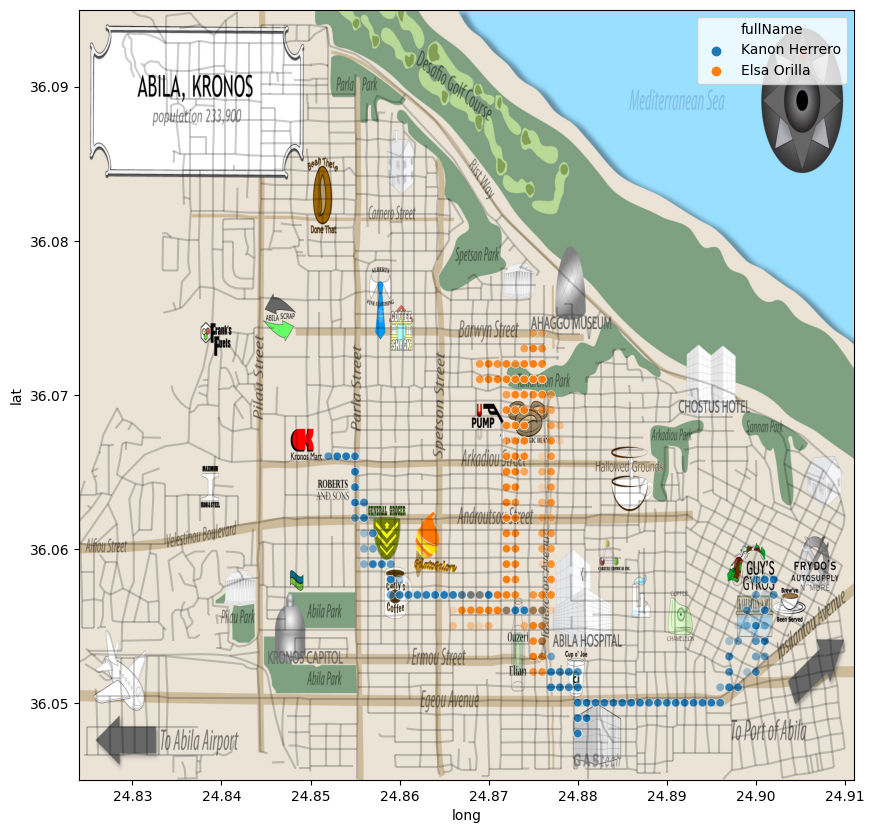

In [28]:
locs = car_gps_df[(car_gps_df['fullName'].isin(['Elsa Orilla', 'Kanon Herrero'])) & (car_gps_df['Date'] == pd.to_datetime('2014-01-07'))]
ax = abila_gdf.plot(alpha=0.2, color='black', figsize=(10,10))
ax.imshow(img, extent=[24.824, 24.911, 36.045, 36.095], aspect='auto')
sns.scatterplot(x=locs['long'], y=locs['lat'], hue=locs['fullName'], ax=ax, alpha=0.2)

In [34]:
overlap = locs.groupby(by=['lat', 'long', 'Timestamp'], as_index=False)['fullName'].count().sort_values(by=['fullName'], ascending=False)
overlap[overlap['fullName'] > 1]

,lat,long,Timestamp,fullName
22,36.048,24.880,2014-01-07 17:37:01,2
11,36.048,24.880,2014-01-07 12:19:01,2
431,36.052,24.875,2014-01-07 17:25:01,2
1304,36.058,24.901,2014-01-07 07:29:01,2
1764,36.066,24.852,2014-01-07 13:28:01,2


At 13:28, 4 minutes after Kanon's transaction was recorded, both their GPS's recorded the same location. In addition, although the two transactions in question have the same amount, one is a credit transaction and one is a loyalty transaction.

In [38]:
transactions[(transactions['location'] == 'Ahaggo Museum') & (transactions['date'] == pd.to_datetime('2014-01-18'))].sort_values(by='price')

/Users/i513604/Desktop/Personal/MSDS/22-Fall/COMP_4449_Capstone/capstone_env/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,timestamp,location,price,FirstName,LastName,fullName,date,type
2824,2014-01-18 00:00:00,Ahaggo Museum,55.55,Elsa,Orilla,Elsa Orilla,2014-01-18,Loyalty
1394,2014-01-18 14:51:00,Ahaggo Museum,55.55,Kanon,Herrero,Kanon Herrero,2014-01-18,Credit
2812,2014-01-18 00:00:00,Ahaggo Museum,120.20,Sven,Flecha,Sven Flecha,2014-01-18,Loyalty


Notice again the top two rows with identical charges.

/Users/i513604/Desktop/Personal/MSDS/22-Fall/COMP_4449_Capstone/capstone_env/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


<AxesSubplot:xlabel='long', ylabel='lat'>

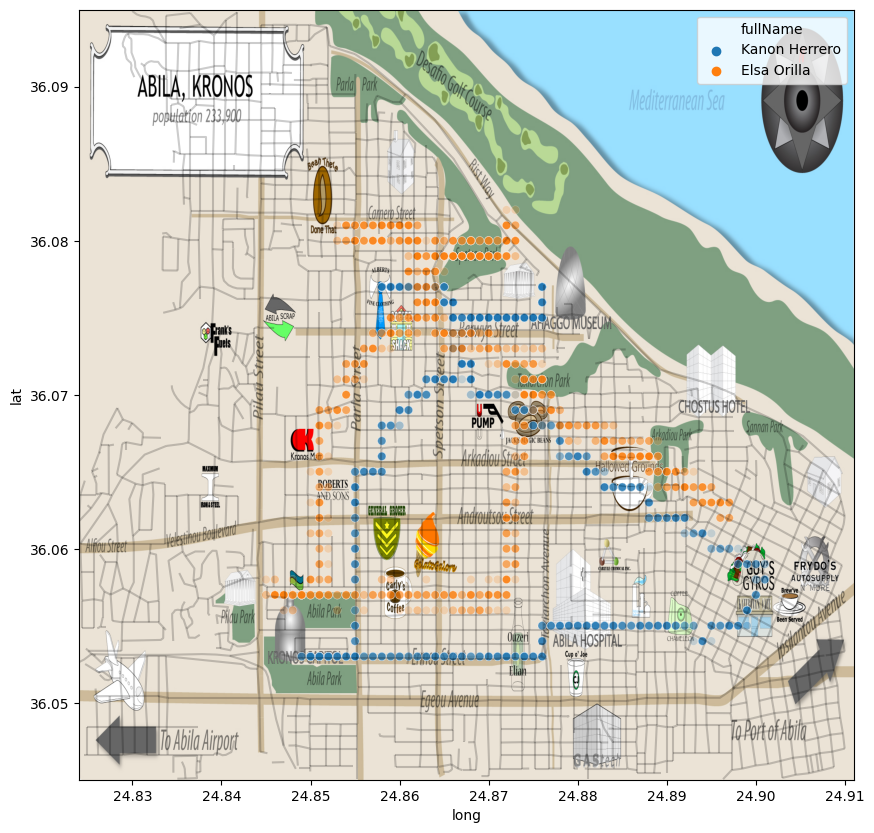

In [39]:
locs = car_gps_df[(car_gps_df['fullName'].isin(['Elsa Orilla', 'Kanon Herrero'])) & (car_gps_df['Date'] == pd.to_datetime('2014-01-18'))]
ax = abila_gdf.plot(alpha=0.2, color='black', figsize=(10,10))
ax.imshow(img, extent=[24.824, 24.911, 36.045, 36.095], aspect='auto')
sns.scatterplot(x=locs['long'], y=locs['lat'], hue=locs['fullName'], ax=ax, alpha=0.2)

In [40]:
overlap = locs.groupby(by=['lat', 'long', 'Timestamp'], as_index=False)['fullName'].count().sort_values(by=['fullName'], ascending=False)
overlap[overlap['fullName'] > 1]

,lat,long,Timestamp,fullName
2394,36.077,24.858,2014-01-18 20:07:01,2
2757,36.080,24.853,2014-01-18 20:07:01,2
3,36.053,24.849,2014-01-18 13:22:01,2
2561,36.077,24.876,2014-01-18 18:42:01,2


In [44]:
locs[locs['Timestamp'] >= pd.to_datetime('2014-01-18 14:30:00')]

,Timestamp,CarID,lat,long,LastName,FirstName,CurrentEmploymentType,CurrentEmploymentTitle,fullName,Date
667229,2014-01-18 18:42:01,22.0,36.077,24.876,Herrero,Kanon,Security,Badging Office,Kanon Herrero,2014-01-18
667230,2014-01-18 18:42:01,22.0,36.077,24.876,Herrero,Kanon,Security,Badging Office,Kanon Herrero,2014-01-18
667231,2014-01-18 18:42:01,28.0,36.082,24.873,Orilla,Elsa,Engineering,Drill Technician,Elsa Orilla,2014-01-18
667232,2014-01-18 18:42:01,28.0,36.081,24.872,Orilla,Elsa,Engineering,Drill Technician,Elsa Orilla,2014-01-18
667233,2014-01-18 18:42:02,22.0,36.077,24.876,Herrero,Kanon,Security,Badging Office,Kanon Herrero,2014-01-18
...,...,...,...,...,...,...,...,...,...,...
672956,2014-01-18 23:59:51,28.0,36.066,24.884,Orilla,Elsa,Engineering,Drill Technician,Elsa Orilla,2014-01-18
672957,2014-01-18 23:59:52,28.0,36.066,24.884,Orilla,Elsa,Engineering,Drill Technician,Elsa Orilla,2014-01-18
672958,2014-01-18 23:59:55,28.0,36.067,24.883,Orilla,Elsa,Engineering,Drill Technician,Elsa Orilla,2014-01-18
672959,2014-01-18 23:59:56,28.0,36.067,24.884,Orilla,Elsa,Engineering,Drill Technician,Elsa Orilla,2014-01-18


Once again we see evidence of both of them being in the same location with one charge on the credit transactions, and one charge on the loyalty. Interestingly, the only record of either one being near the museum is almost 4 hours after the transaction was recorded.